---

title: "K-means 算法讲解"
date: 2024-07-05
author: 郝鸿涛
slug: k-means
draft: false
toc: true
tags: ML

---

In [50]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation, FFMpegWriter

## 算法讲解

K-means 的作用是将数据分类。下面我们用最简单的例子来举例，然后一步步手动写出该算法 (不调用出 pandas, numpy 和 matploblib 之外的任何包)。

下面我们有 200 个随机的二维数据点：

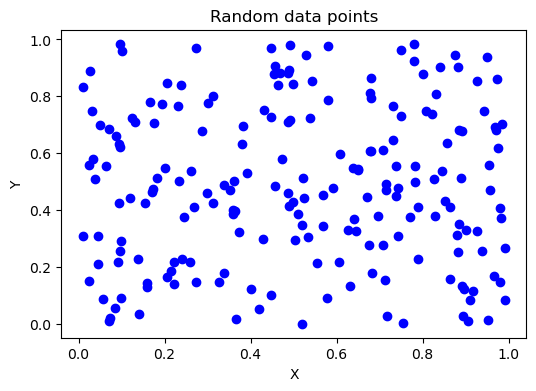

In [51]:
data = np.random.rand(200, 2)
plt.figure(figsize=(6,4))
plt.scatter(data[:, 0], data[:, 1], c="blue", marker="o")
plt.title("Random data points")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

我们的任务是将上面的 200 个点划分为 $k$ 类。K-means 的算法步骤为下：
1. 随机选取 $k$ 个点作为最初始的中心点 (centroid)
2. 对 200 个点中的每个点 $i$，计算该点与每个中心点 (centroid) 的距离。如果距离第一个中心点最近，那 $i$ 归为第一类，以此类推。
3. 对每一个类中的所有点，取平均值，得到新的 $k$ 个中心点。
4. 重复第二步与第三步，直到中心点无法继续更新（或者满足你自定义的条件，比如，新的中心点与之前的距离非常近）

## 写初步代码

下面，我们按照上面的步骤简单写一下 K-means。

In [52]:
# 数据维度，我们这里是二维的，也就是只有 x, y
n = 2
# 将数据分为多少个类
k = 2
# 最初的随机中心点
initial_centroids = np.random.rand(k, n)
# 初始化 clusters。clusters 为一个 list，该 list 包含 k 个子 list。每个子 list 是一个类
# 其里面的元素为划为该类的数据点
clusters = [[] for _ in range(k)]
# 对于每一个点
for d in data:
    # 计算该点与每一个中心点的距离
    distances = [np.linalg.norm(d - initial_centroids[c]) for c in range(k)]
    # 看看距离哪一个中心点更近
    min_distances_idx = np.argmin(distances)
    # 将该点放进距离较近的中心点 (centroid) 所在的类别 (cluster)
    clusters[min_distances_idx].append(d)
# 更新了 clusters  之后，我们继续更新 centroids。此时，两个 centroids 分别是各自所在 cluster 的中心，
# 也就是 mean
# axis = 0, by column
updated_centroids = np.array([np.mean(clusters[c], axis = 0) for c in range(k)])

好，我们已经更新了 clusters 和 centroids，让我们来看看现在的情况如何：

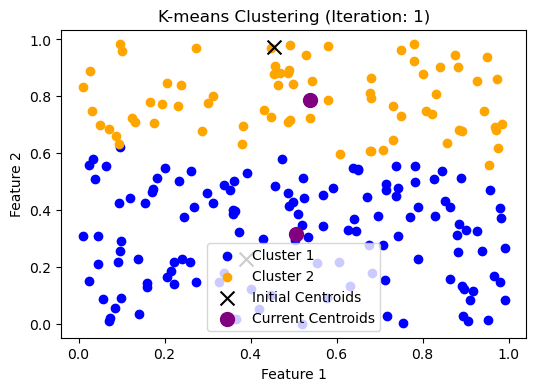

In [53]:
colors = ['b', 'orange', 'g', 'r', 'y', 'c', 'm']
plt.figure(figsize = (6, 4))
for i, cluster in enumerate(clusters):
    cluster = np.array(cluster)
    plt.scatter(cluster[:, 0], cluster[:, 1], c = colors[i], label=f"Cluster {i+1}")
plt.scatter(
    initial_centroids[:, 0], 
    initial_centroids[:, 1],
    c='k',
    marker='x',
    s = 100,
    label="Initial Centroids"
)
plt.scatter(
    updated_centroids[:, 0], 
    updated_centroids[:, 1],
    c='purple',
    marker='o',
    s = 100,
    label="Current Centroids"
)
plt.title("K-means Clustering (Iteration: 1)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


我们继续：

In [54]:
# 需要重新初始化 clusters
clusters = [[] for _ in range(k)]
# 对于每一个点
for d in data:
    # 计算该点与每一个中心点的距离
    distances = [np.linalg.norm(d - updated_centroids[c]) for c in range(k)]
    # 看看距离哪一个中心点更近
    min_distances_idx = np.argmin(distances)
    # 将该点放进距离较近的中心点 (centroid) 所在的类别 (cluster)
    clusters[min_distances_idx].append(d)
# 更新了 clusters  之后，我们继续更新 centroids。此时，两个 centroids 分别是各自所在 cluster 的中心，
# 也就是 mean
# axis = 0, by column
updated_centroids = np.array([np.mean(clusters[c], axis = 0) for c in range(k)])

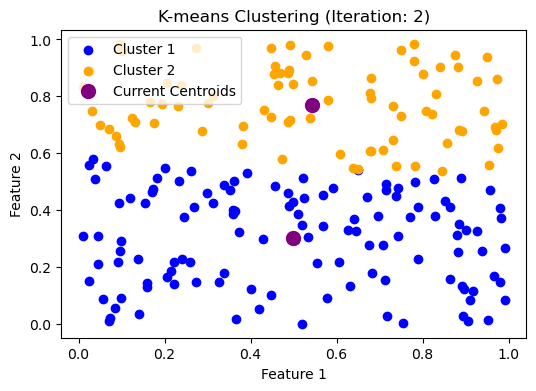

In [55]:
colors = ['b', 'orange', 'g', 'r', 'y', 'c', 'm']
plt.figure(figsize = (6, 4))
for i, cluster in enumerate(clusters):
    cluster = np.array(cluster)
    plt.scatter(cluster[:, 0], cluster[:, 1], c = colors[i], label=f"Cluster {i+1}")
plt.scatter(
    updated_centroids[:, 0], 
    updated_centroids[:, 1],
    c='purple',
    marker='o',
    s = 100,
    label="Current Centroids"
)
plt.title("K-means Clustering (Iteration: 2)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

好，我们就不继续一步步做了。上面代码的问题是，每一步都需要重新写代码，这样不行。我们需要实现自动化。

## 普适性代码

In [56]:
def kmeans_clustering(data, centroids):
    """
    Inputs:
      - data: data points to cluster 
      - centroids: previous centroids
    
    Outputs:
      - updated_centoids:
      - clusters: a list. 
        Each list contains all arrays which are data points classified into this cluster
    """
    # num of clusters
    k = len(centroids)
    # initialize empty clusters
    clusters = [[] for _ in range(k)]
    # for each data point
    for d in data:
        # calcuate distance from each centroid to this data point
        distances = np.linalg.norm(d - centroids, axis = 1)
        # the index of centroid that is the closest to this data point
        min_distance_idx = np.argmin(distances)
        # add this data point to the associated cluster
        clusters[min_distance_idx].append(d)
    # update centroids by calculating mean of each cluster
    updated_centroids = np.array([np.mean(clusters[c], axis = 0) for c in range(k)])
    return updated_centroids, clusters

In [57]:
def make_plot(clusters, centroids, iteration):
    # Plotting the results
    colors = ['b', 'g', 'r', 'y', 'c', 'm']
    plt.figure(figsize=(6, 4))
    for i, cluster in enumerate(clusters):
        cluster = np.array(cluster)
        if len(cluster) > 0:
            plt.scatter(cluster[:, 0], cluster[:, 1], 
                        c=colors[i], label=f'Cluster {i+1}')

    # plt.scatter(initial_centroids[:, 0], initial_centroids[:, 1], c='k', marker='x', s=100, label='Initial Centroids')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='k', 
                marker='o', s=100, label='Centroids')
    plt.title(f'K-means Clustering (Iteration: {iteration})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

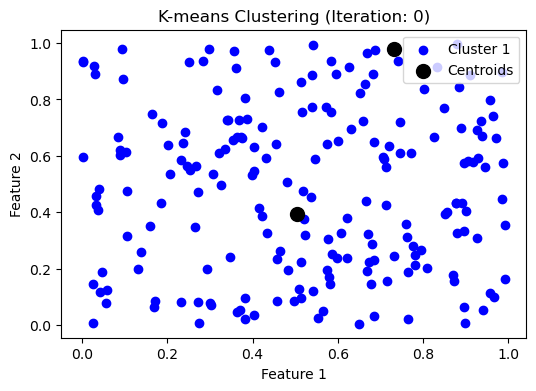

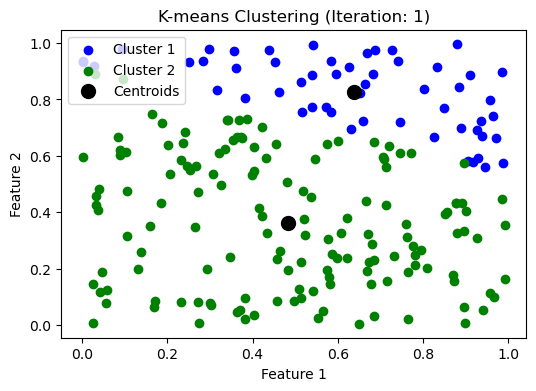

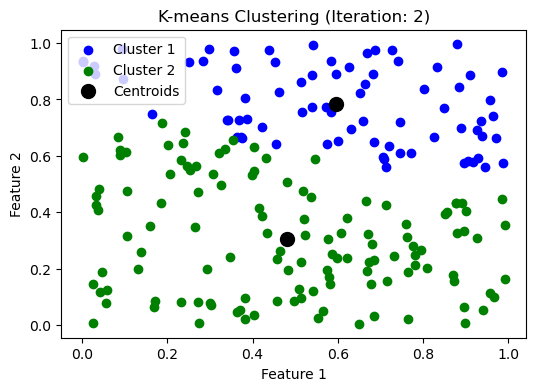

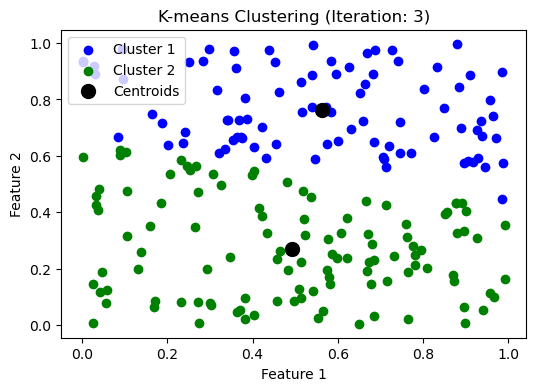

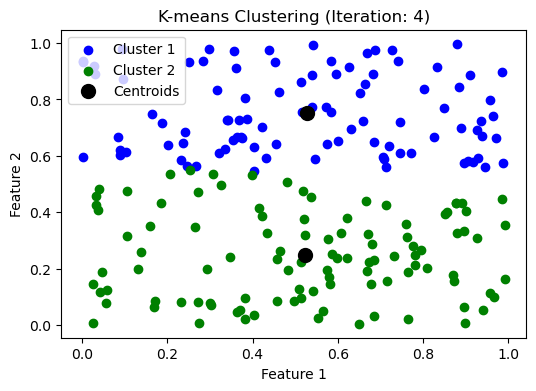

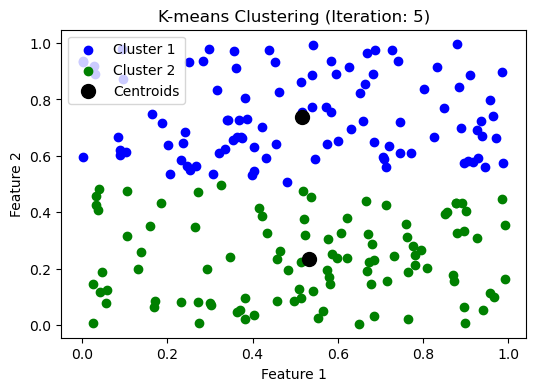

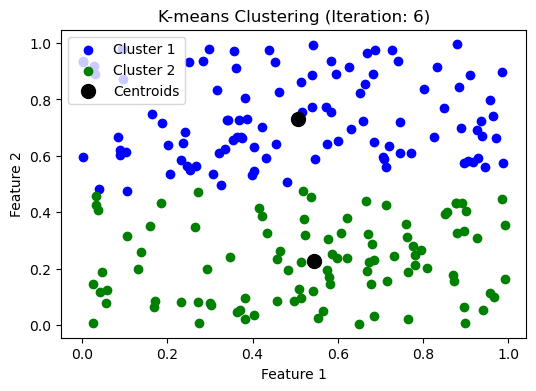

In [58]:
# num of dimensions
n = 2
# num of clusters
k = 2
# Convergence criteria
threshold = 1e-2
# generate random data 
data = np.random.rand(200, n)
# random centroids as an initial stage; a k by n matrix
initial_centroids = np.random.rand(k, n) 
# update centroids and clusters using our previous function
updated_centroids, clusters = kmeans_clustering(data, initial_centroids)
# num of iterations
iteration = 0
centroids = initial_centroids
# plot the initial state
make_plot([data], centroids, iteration)

# np.max(np.linalg.norm(updated_centroids - centroids, axis=1))
# this calculates the max shift among centroid shifts
while np.max(np.linalg.norm(updated_centroids - centroids, axis=1)) > threshold:
    iteration += 1
    make_plot(clusters, updated_centroids, iteration)
    # updated centroids 
    centroids = updated_centroids
    updated_centroids, clusters = kmeans_clustering(data, centroids)

## 制作动画

上面的代码我们可以把每一步画出来，我们试试制作一个动画。

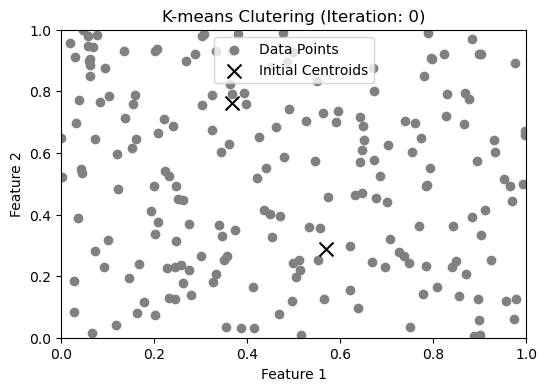

In [59]:
fig, ax = plt.subplots(figsize = (6, 4))
# Convergence criteria
threshold = 1e-3
# generate random data 
data = np.random.rand(200, n)
# random centroids as an initial stage; a k by n matrix
initial_centroids = np.random.rand(k, n) 
centroids = initial_centroids.copy()

def update(frame):
    global centroids
    ax.clear()
    ax.set_title(f"K-means Clutering (Iteration: {frame})")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

    # plot nitial stage where there are two random centroids
    if frame == 0:
        ax.scatter(data[:, 0], data[:, 1], c="gray", label="Data Points")
        ax.scatter(centroids[:, 0], centroids[:, 1],
                   c='k', marker='x', s=100, label='Initial Centroids'
        )
        ax.legend()
        return
    
    # update centroids and clusters using our previous function
    updated_centroids, clusters = kmeans_clustering(data, centroids)

    # make plot
    colors = ['b', 'g', 'r', 'y', 'c', 'm']
    for j, cluster in enumerate(clusters):
        cluster = np.array(cluster)
        if len(cluster) > 0:
            ax.scatter(cluster[:, 0], cluster[:, 1], c=colors[j % len(colors)], label=f'Cluster {j+1}')
    # plot centroids
    ax.scatter(updated_centroids[:, 0], updated_centroids[:, 1], c='k', 
                marker='o', s=100, label='Centroids')
    ax.legend()

    # Check for convergence
    max_centroid_change = np.max(np.linalg.norm(updated_centroids - centroids, axis=1))
    if max_centroid_change < threshold:
        anim.event_source.stop()
        return

    # Update centroids
    centroids = updated_centroids

# Create the animation
anim = FuncAnimation(fig, update, frames=np.arange(20), interval=1000, repeat=False)

writer = FFMpegWriter(fps=1)  # Adjust fps as needed
anim.save("img/kmeans_clustering.mp4", writer=writer)

# Show the animation
# plt.show()

上面的动画视频在 [这里](/cn/blog/2024-07-05-kmeans_files/kmeans_clustering.mp4)

## 评估结果

我们现在重点不在可视化，我们主要看一下我们的代码是否正确。

In [60]:
def get_final_centroids_and_clusters(data, n_clusters, threshold, seed=None):
    """
    Perform K-means clustering on the provided data.
    
    Parameters:
        data (numpy.ndarray): Data points to cluster.
        n_clusters (int): Number of clusters.
        threshold (float): Convergence threshold.
        seed (int, optional): Random seed for reproducibility.
    
    Returns:
        updated_centroids (numpy.ndarray): Final centroids after clustering.
        clusters (list): Data points classified into clusters.
    """
    if seed is not None:
        np.random.seed(seed)
    
    data_size = data.shape[0]
    # Initialize centroids by randomly sampling from the data
    initial_centroids = data[np.random.choice(data_size, n_clusters, replace=False)]
    updated_centroids, clusters = kmeans_clustering(data, initial_centroids)
    centroids = initial_centroids
    
    while np.max(np.linalg.norm(updated_centroids - centroids, axis=1)) > threshold:
        centroids = updated_centroids
        updated_centroids, clusters = kmeans_clustering(data, centroids)
    
    return updated_centroids, clusters

def kmeans_clustering(data, centroids):
    """
    Perform one iteration of K-means clustering.
    
    Parameters:
        data (numpy.ndarray): Data points to cluster.
        centroids (numpy.ndarray): Current centroids.
    
    Returns:
        updated_centroids (numpy.ndarray): Updated centroids.
        clusters (list): Data points classified into clusters.
    """
    k = len(centroids)
    clusters = [[] for _ in range(k)]
    
    for d in data:
        # Calculate distances from the data point to each centroid
        distances = np.linalg.norm(d - centroids, axis=1)
        # Find the index of the closest centroid
        min_distance_idx = np.argmin(distances)
        # Assign the data point to the closest centroid's cluster
        clusters[min_distance_idx].append(d)
    
    updated_centroids = []
    for cluster in clusters:
        if cluster:
            updated_centroids.append(np.mean(cluster, axis=0))
        else:
            # Handle empty cluster by reinitializing the centroid randomly from the data
            updated_centroids.append(data[np.random.choice(data.shape[0])])
    
    return np.array(updated_centroids), clusters


In [65]:
height_weight_df = pd.read_csv("data/height_weight_data.csv")
height_weight_data = height_weight_df[['Height', 'Weight']].values
final_centroids, clusters = get_final_centroids_and_clusters(
    height_weight_data, n_clusters=2, threshold=1e-3, seed = 0
)
final_centroids

array([[150.04743075,  59.32777344],
       [171.59570541,  80.42337816]])

In [66]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(height_weight_data)
kmeans.cluster_centers_

array([[150.04743075,  59.32777344],
       [171.59570541,  80.42337816]])

我们看到我们的结果和 `sklearn` 的一致，那说明我们的没问题。但是缺少了一个功能：预测。比如，我随便给你一个数据点，`[130, 66]`，它属于 cluster1 还是 cluster2？

我们接下来实现这个功能。

In [71]:
def predict(data, final_centroids):
    """
    Predict the closest cluster each data point in the data belongs to.
    
    Parameters:
        data (numpy.ndarray): Data points to predict.
    
    Returns:
        labels (numpy.ndarray): Cluster labels for each data point.
    """
    k = len(data)
    labels = []

    for d in data:
        # Calculate distances from the data point to each centroid
        distances = np.linalg.norm(d - final_centroids, axis=1)
        # Find the index of the closest centroid
        min_distance_idx = np.argmin(distances)
        # That index is the label
        labels.append(min_distance_idx)
    return np.array(labels)
    

In [72]:
predict([[130, 66], [144, 55]], final_centroids), kmeans.predict([[130, 66], [144, 55]])

(array([0, 0]), array([0, 0], dtype=int32))

我们可以看到，我们写的这个函数，其结果和 `sklearn` 的结果一致。

## 进一步深化

接下来，我们要写一个 Python Class，而不是用三个独立的 `def`。

In [74]:
class KMeans:
    def __init__(self, n_clusters, threshold, seed=None):
        """
        Initialize the KMeans class with the number of clusters, convergence threshold, and optional random seed.
        
        Parameters:
            n_clusters (int): Number of clusters.
            threshold (float): Convergence threshold.
            seed (int, optional): Random seed for reproducibility.
        """
        self.n_clusters = n_clusters
        self.threshold = threshold 
        self.seed = seed 
        self.centroids = None
    
    def fit(self, data):
        """
        Fit the K-means algorithm to the data.
        
        Parameters:
            data (numpy.ndarray): Data points to cluster.
        
        Returns:
            self (KMeans): Fitted KMeans instance.
        """
        if self.seed is not None:
            np.random.seed(self.seed)
        data_size = data.shape[0]
        # Initialize centroids by randomly sampling from the data
        initial_centroids = data[np.random.choice(data_size, self.n_clusters, replace=False)]
        updated_centroids, clusters = kmeans_clustering(data, initial_centroids)
        centroids = initial_centroids

        while np.max(np.linalg.norm(updated_centroids - centroids, axis=1)) > self.threshold:
            centroids = updated_centroids
            updated_centroids, clusters = self._kmeans_clustering(data, centroids)
        
        self.centroids = updated_centroids
        self.clusters = clusters
        
        return self 
    
    def _kmeans_clustering(self, data, centroids):
        """
        Perform one iteration of K-means clustering.
        
        Parameters:
            data (numpy.ndarray): Data points to cluster.
            centroids (numpy.ndarray): Current centroids.
        
        Returns:
            updated_centroids (numpy.ndarray): Updated centroids.
            clusters (list): Data points classified into clusters.
        """
        k = len(centroids)
        clusters = [[] for _ in range(k)]
        
        for d in data:
            # Calculate distances from the data point to each centroid
            distances = np.linalg.norm(d - centroids, axis=1)
            # Find the index of the closest centroid
            min_distance_idx = np.argmin(distances)
            # Assign the data point to the closest centroid's cluster
            clusters[min_distance_idx].append(d)
        
        updated_centroids = []
        for cluster in clusters:
            if cluster:
                updated_centroids.append(np.mean(cluster, axis=0))
            else:
                # Handle empty cluster by reinitializing the centroid randomly from the data
                updated_centroids.append(data[np.random.choice(data.shape[0])])
        
        return np.array(updated_centroids), clusters
    
    def predict(self, data):
        """
        Predict the closest cluster each data point in the data belongs to.
        
        Parameters:
            data (numpy.ndarray): Data points to predict.
        
        Returns:
            labels (numpy.ndarray): Cluster labels for each data point.
        """
        labels = []

        for d in data:
            # Calculate distances from the data point to each centroid
            distances = np.linalg.norm(d - self.centroids, axis=1)
            # Find the index of the closest centroid
            min_distance_idx = np.argmin(distances)
            # That index is the label
            labels.append(min_distance_idx)
        return np.array(labels)

# Example usage:
# kmeans = KMeans(n_clusters=3, threshold=0.001, seed=42)
# kmeans.fit(data)
# labels = kmeans.predict(data)

In [80]:
kmeans = KMeans(n_clusters=2, threshold=0.001, seed = 0)
kmeans_result = kmeans.fit(height_weight_data)
kmeans_result.centroids

array([[150.04743075,  59.32777344],
       [171.59570541,  80.42337816]])

In [81]:
kmeans.predict([[130, 66], [144, 55]])

array([0, 0])